Import & cấu hình

In [176]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import sparse
from scipy.sparse.linalg import splu

plt.style.use("seaborn-v0_8")
np.set_printoptions(precision=4, suppress=True)

Load dataset

In [177]:
DATA_DIR = "dataset_large"

df_w = pd.read_csv(f"{DATA_DIR}/warehouses.csv")
df_c = pd.read_csv(f"{DATA_DIR}/customers.csv")
df_cost = pd.read_csv(f"{DATA_DIR}/cost_params.csv")

print(f"Warehouses: {len(df_w)}")
print(f"Customers: {len(df_c)}")
print(f"Edges: {len(df_cost)}")


Warehouses: 60
Customers: 150
Edges: 4151


Xây dựng QP từ bài toán vận tải

In [178]:
def build_qp(df_w, df_c, df_cost):
    S = df_w.set_index("id")["supply"].to_dict()
    D = df_c.set_index("id")["demand"].to_dict()

    edges_i = df_cost["i"].values
    edges_j = df_cost["j"].values
    a = df_cost["a_ij"].values
    b = df_cost["b_ij"].values

    n_var = len(a)

    # Objective
    P = sparse.diags(2 * a, format="csc")
    q = b.copy()

    # Constraints
    row, col, data = [], [], []

    cust_ids = df_c["id"].values
    wh_ids = df_w["id"].values

    cust_row = {cid: i for i, cid in enumerate(cust_ids)}
    wh_row = {wid: i + len(cust_ids) for i, wid in enumerate(wh_ids)}

    for e in range(n_var):
        row.append(cust_row[edges_j[e]])
        col.append(e)
        data.append(1)

        row.append(wh_row[edges_i[e]])
        col.append(e)
        data.append(1)

        row.append(len(cust_ids) + len(wh_ids) + e)
        col.append(e)
        data.append(1)

    n_con = len(cust_ids) + len(wh_ids) + n_var
    A = sparse.coo_matrix((data, (row, col)), shape=(n_con, n_var)).tocsc()

    INF = 1e30
    l = np.zeros(n_con)
    u = np.zeros(n_con)

    for cid in cust_ids:
        r = cust_row[cid]
        l[r] = u[r] = D[cid]

    for wid in wh_ids:
        r = wh_row[wid]
        l[r] = -INF
        u[r] = S[wid]

    l[len(cust_ids)+len(wh_ids):] = 0
    u[len(cust_ids)+len(wh_ids):] = INF

    return P, q, A, l, u


Thuật toán ADMM (CUSTOM SOLVER)

In [179]:
import time
def admm_qp(P, q, A, l, u, rho=0.1, alpha=1.6, max_iter=20000):
    n, m = P.shape[0], A.shape[0]

    K = (P + rho * (A.T @ A)).tocsc()
    K_lu = splu(K)

    x = np.zeros(n)
    z = np.zeros(m)
    y = np.zeros(m)
    start_time = time.time()
    history = {
    "iter": [],
    "obj": [],
    "r_pri": [],
    "r_dual": []
    }

    log_every = 10      

    eps_abs = 1e-4
    eps_rel = 1e-4

    for k in range(max_iter):
        # x-update
        x = K_lu.solve(-q + rho * A.T @ (z - y))

        Ax = A @ x

        # relaxation (GIỐNG .py)
        Ax_hat = alpha * Ax + (1 - alpha) * z

        # z-update
        z_new = np.minimum(np.maximum(Ax_hat + y, l), u)

        # y-update
        y_new = y + (Ax_hat - z_new)

        # residuals
        r_pri = np.linalg.norm(Ax - z_new)
        r_dual = np.linalg.norm(rho * (A.T @ (z_new - z)))

        eps_pri = np.sqrt(m) * eps_abs + eps_rel * max(np.linalg.norm(Ax), np.linalg.norm(z_new))
        eps_dual = np.sqrt(n) * eps_abs + eps_rel * np.linalg.norm(A.T @ y_new)

        z, y = z_new, y_new
        if k % log_every == 0:
            obj_val = 0.5 * x @ (P @ x) + q @ x

            history["iter"].append(k)
            history["obj"].append(obj_val)
            history["r_pri"].append(r_pri)
            history["r_dual"].append(r_dual)
            if k % (log_every*10) == 0:
                print(
                    f"iter={k:6d} | "
                    f"obj={obj_val:12.6f} | "
                    f"r_pri={r_pri:.3e} | "
                    f"r_dual={r_dual:.3e}"
                )
        if r_pri <= eps_pri and r_dual <= eps_dual:
            obj_val = 0.5 * x @ (P @ x) + q @ x
            print(
                f"Converged at iter={k} | "
                f"obj={obj_val:.6f} | "
                f"r_pri={r_pri:.3e} | "
                f"r_dual={r_dual:.3e}"
            )
            break
    end_time = time.time()
    history["solve_time"] = end_time - start_time          
    return x, history


Chạy solver & lưu nghiệm

In [180]:
P, q, A, l, u = build_qp(df_w, df_c, df_cost)
x_opt, hist = admm_qp(P, q, A, l, u)

df_sol = df_cost.copy()
df_sol["x_ij"] = x_opt

df_sol.head()
print("Solve time (seconds):", hist["solve_time"])

iter=     0 | obj=-6237571.004963 | r_pri=6.460e+03 | r_dual=1.679e+03
iter=   100 | obj=51733.921039 | r_pri=3.250e+01 | r_dual=5.549e+00
iter=   200 | obj=39134.989628 | r_pri=1.530e+01 | r_dual=1.253e+00
iter=   300 | obj=43157.935778 | r_pri=9.970e+00 | r_dual=1.008e+00
iter=   400 | obj=44790.222553 | r_pri=6.683e+00 | r_dual=7.080e-01
iter=   500 | obj=46030.656382 | r_pri=5.043e+00 | r_dual=2.811e-01
iter=   600 | obj=49611.264016 | r_pri=3.205e+00 | r_dual=2.568e-01
iter=   700 | obj=50228.853482 | r_pri=2.164e+00 | r_dual=1.957e-01
iter=   800 | obj=50279.979675 | r_pri=1.574e+00 | r_dual=1.240e-01
iter=   900 | obj=50414.281378 | r_pri=1.301e+00 | r_dual=1.013e-01
iter=  1000 | obj=50830.152536 | r_pri=9.445e-01 | r_dual=9.424e-02
iter=  1100 | obj=51073.585935 | r_pri=7.579e-01 | r_dual=6.519e-02
iter=  1200 | obj=51157.017731 | r_pri=5.505e-01 | r_dual=4.965e-02
iter=  1300 | obj=51237.755836 | r_pri=4.175e-01 | r_dual=4.140e-02
iter=  1400 | obj=51162.890652 | r_pri=3.664e

In [181]:
# Tổng chi phí
total_cost = (df_sol["a_ij"] * df_sol["x_ij"]**2 + df_sol["b_ij"] * df_sol["x_ij"]).sum()

num_warehouses = df_w.shape[0]
num_customers = df_c.shape[0]
num_routes_used = (df_sol["x_ij"] > 1e-6).sum()

print("===== KPI TỔNG QUAN =====")
print(f"Số kho                : {num_warehouses}")
print(f"Số khách              : {num_customers}")
print(f"Số tuyến có flow > 0  : {num_routes_used}")
print(f"Tổng chi phí tối ưu Z*: {total_cost:.2f}")


===== KPI TỔNG QUAN =====
Số kho                : 60
Số khách              : 150
Số tuyến có flow > 0  : 2067
Tổng chi phí tối ưu Z*: 51299.99


BAR CHART: TẢI CỦA TỪNG KHO

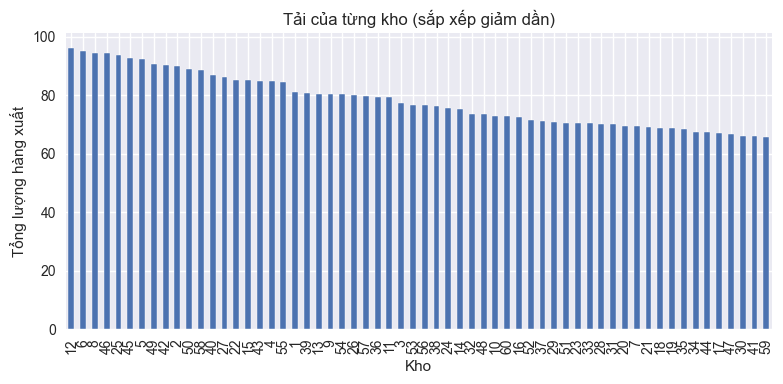

In [182]:
import matplotlib.pyplot as plt

warehouse_load = (
    df_sol.groupby("i")["x_ij"]
    .sum()
    .sort_values(ascending=False)
)

plt.figure(figsize=(8, 4))
warehouse_load.plot(kind="bar")
plt.xlabel("Kho")
plt.ylabel("Tổng lượng hàng xuất")
plt.title("Tải của từng kho (sắp xếp giảm dần)")
plt.tight_layout()
plt.show()


HISTOGRAM: SỐ KHO PHỤC VỤ MỖI KHÁCH (MULTI-SOURCING)

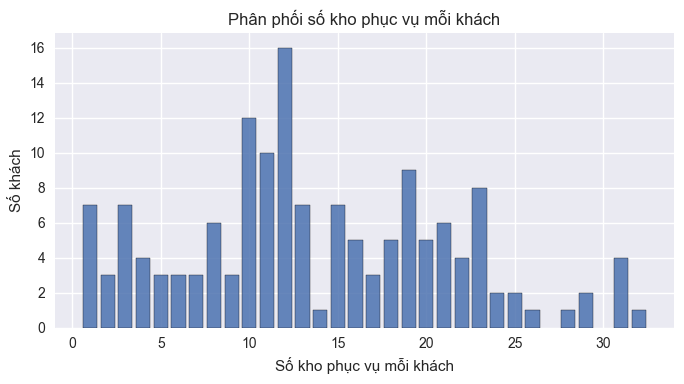

In [183]:
customer_sources = (
    df_sol[df_sol["x_ij"] > 1e-6]
    .groupby("j")
    .size()
)

counts = customer_sources.value_counts().sort_index()

plt.figure(figsize=(7, 4))
plt.bar(
    counts.index,
    counts.values,
    color="#4C72B0",
    edgecolor="black",
    alpha=0.85
)

plt.xlabel("Số kho phục vụ mỗi khách")
plt.ylabel("Số khách")
plt.title("Phân phối số kho phục vụ mỗi khách")
plt.tight_layout()
plt.show()



HISTOGRAM: PHÂN PHỐI FLOW TRÊN CÁC TUYẾN

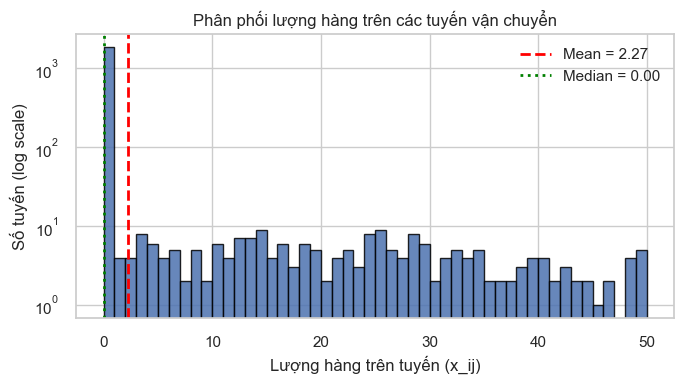

In [184]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

# Chỉ lấy các tuyến thực sự có flow
flows = df_sol["x_ij"][df_sol["x_ij"] > 1e-6]

mean_flow = flows.mean()
median_flow = flows.median()

plt.figure(figsize=(7, 4))

plt.hist(
    flows,
    bins=50,
    color="#4C72B0",
    edgecolor="black",
    alpha=0.85
)

plt.yscale("log")

plt.axvline(mean_flow, color="red", linestyle="--", linewidth=2,
            label=f"Mean = {mean_flow:.2f}")
plt.axvline(median_flow, color="green", linestyle=":", linewidth=2,
            label=f"Median = {median_flow:.2f}")

plt.xlabel("Lượng hàng trên tuyến (x_ij)")
plt.ylabel("Số tuyến (log scale)")
plt.title("Phân phối lượng hàng trên các tuyến vận chuyển")
plt.legend()
plt.tight_layout()
plt.show()


CHỌN TOP-K KHO & KHÁCH

In [185]:
import numpy as np
import seaborn as sns

top_k_warehouses = 10
top_k_customers = 20

# Top kho theo tổng tải
top_w = warehouse_load.head(top_k_warehouses).index

# Top khách theo tổng lượng nhận
top_c = (
    df_sol.groupby("j")["x_ij"]
    .sum()
    .sort_values(ascending=False)
    .head(top_k_customers)
    .index
)


Vẽ heatmap

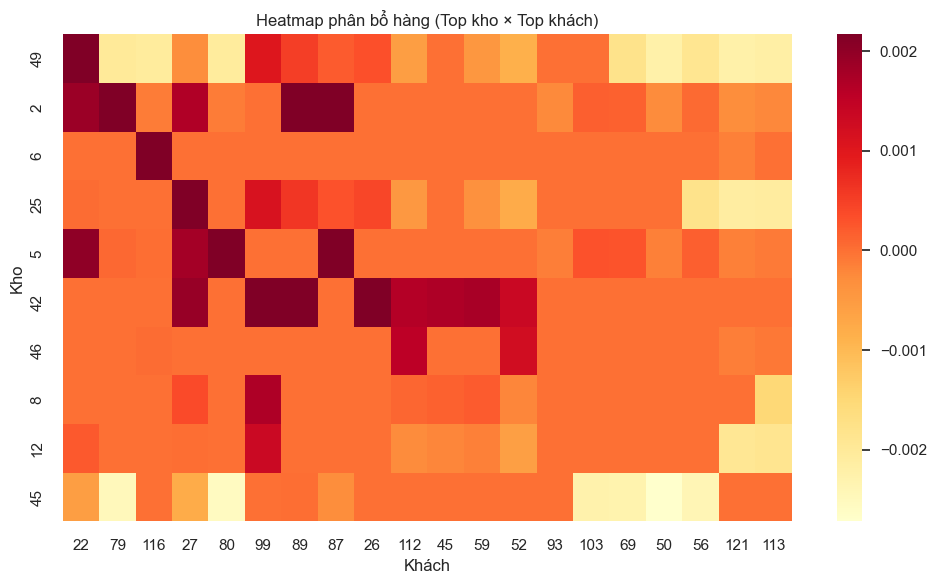

In [186]:
filtered = df_sol[
    df_sol["i"].isin(top_w) & df_sol["j"].isin(top_c)
]

pivot = filtered.pivot(index="i", columns="j", values="x_ij").fillna(0)

# sắp xếp cho dễ nhìn (khuyến nghị)
pivot = pivot.loc[pivot.sum(axis=1).sort_values(ascending=False).index]
pivot = pivot[pivot.sum(axis=0).sort_values(ascending=False).index]

plt.figure(figsize=(10, 6))
sns.heatmap(
    pivot,
    cmap="YlOrRd",
    vmax=np.percentile(pivot.values, 95)
)
plt.xlabel("Khách")
plt.ylabel("Kho")
plt.title("Heatmap phân bổ hàng (Top kho × Top khách)")
plt.tight_layout()
plt.show()


HỘI TỤ THUẬT TOÁN ADMM

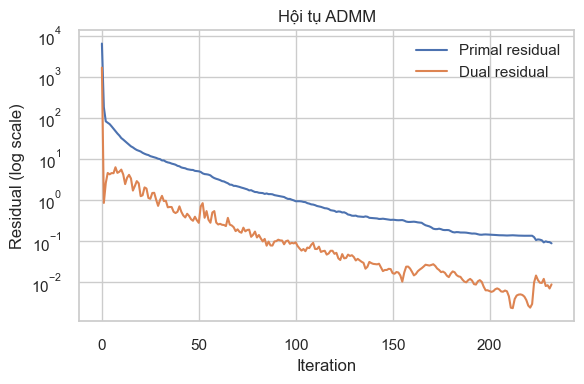

In [187]:
plt.figure(figsize=(6, 4))
plt.plot(hist["r_pri"], label="Primal residual")
plt.plot(hist["r_dual"], label="Dual residual")
plt.yscale("log")
plt.xlabel("Iteration")
plt.ylabel("Residual (log scale)")
plt.legend()
plt.title("Hội tụ ADMM")
plt.tight_layout()
plt.show()
